## Package Description

`bmdrc` is a python library for calculating **B**ench**m**ark **D**ose **R**esponse **C**urves. This tutorial will take users through the library using a dichotomous (binary response) example. `bmdrc` is broken up into five modules 

1. *Input Data Module:* Import data into the python library.

2. *Pre-Processing Module:* Combine and remove endpoints as needed.

3. *Filtering Modules:* Apply recommended filters from the EPA and statistics experts.

4. *Model Fitting Modules:* Fit recommended models from the EPA and experts. The best fit model is autoselected for you.

5. *Output Modules:* Select tables to output as csvs. View plots in a HTML report.

First, install the package from pip using: 

`pip install bmdrc`

Or from github using: 

`pip install git+https://github.com/PNNL-CompBio/bmdrc`

## Datatype Description

**Dichotomous Data**

- *BinaryClass* The `BinaryClass` object contains specific pre-processing and filtering functions that pertain to plates and wells. Each value should be a 0, 1, or NA, and *bmdrc* will caculate the response column. The following columns are needed for data in long and wide format: chemical, plate, well, concentration. The following columns are only needed for data in wide format: endpoint, value. 

- *ProportionalClass* If your data does not contain plates and wells, the `ProportionalClass` object only requires a chemical, endpoint, concentration, and response (a proportion ranging from 0 to 1). Data must be in long format. 

- *LPRClass* In the `LPRClass`, larval photomotor response data can be converted to dichotomous as described in [Thomas et al 2019](https://www.sciencedirect.com/science/article/pii/S2468111318300732). Data must be in long format and contain the following columns: chemical, plate, well, concentration, time, and value. Users must specify the time between cycles, the cooldown time between cycles, and whether to start with a light or dark cycle. If this format does not fit your data nicely, please report it to the issues tab. 

**Continuous Data**

- *ContinuousClass* The `ContinuousClass` object requires only four columns: chemical, endpoint, concentration, and response (a continuous variable with any range). All selected models support negative numbers and zeroes. NA values are automatically filtered out. Optionally, an ANOVA can be fit to determine if there's differences in concentrations, with checks to ensure an ANOVA model is appropriate for the given dataset.


In [1]:
# Load local libraries
import bmdrc 
import pandas as pd

## Module 1: Input Data Module 

The first step to using the bmdrc python library is to properly format the data. For dichotmous data without plate or well information, use the `ProportionalClass` object which can be imported using `from bmdrc.ProportionalClass import ProportionalClass`. Next, read the data as a pandas dataframe. The data must be in long format. You will need four columns - the chemical, the endpoint, the concentration, and the response value which must range between 0 and 1. Remove NAs before making the `ProportionalClass` object.

In [2]:
from bmdrc.ProportionalClass import ProportionalClass

res_only = ProportionalClass(
    df = pd.read_table("../data/ToxExample_Long.txt"), # Input is a pandas DataFrame
    chemical = "chemical.id", # The name of the chemical column 
    endpoint = "endpoint", # The name of the column with endpoints
    concentration = "concentration", # The name of the concentration column
    response = "response" # The name of the column with response value ranging from 0 to 1
)

## Module 2: Pre-Processing Modules

These modules allow for the creation of new endpoints from existing ones, the removal of wells with specific variables (like "DNC" which stands for "Do Not Count"), and the removal of endpoints that shouldn't be modeled. Here, only removing endpoints is applicable, as new endpoints cannot be created since they depend on the absence/presence (0/1) *and* wells cannot be set to NA as there is no well information.

#### Remove Endpoints

In [3]:
res_only.remove_endpoints(endpoint_name = "DNC")
res_only.df["endpoint"].unique()

array(['202992', 'Endpoint1', 'Endpoint2'], dtype=object)

## Module 3: Filtering Modules

The EPA has recommendations for filters and filter values to minimize potential errors when calculating benchmark dose response curves. Filter parameters and filtered data are tracked in attributes for report-building purposes.

**Negative Control Filter:** Not used, as the assumption is that plates with unusually high responses should be removed. Here, there is no plate information. 

#### Minimum Concentration Filter
Another recommendation from the EPA is that any endpoints with less than 3 measurements for a specific endpoint should be tossed entirely. The default is 3. 

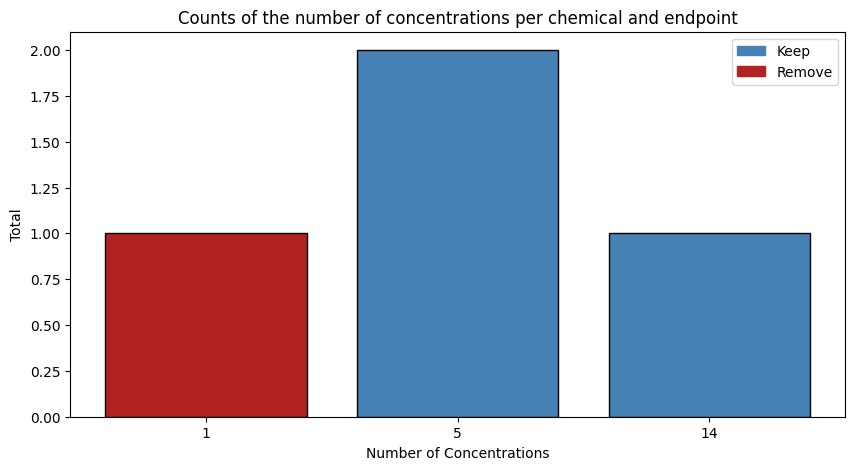

In [4]:
# Set the percentage and build the diagnostic plot, but don't actually apply the filter. 
res_only.filter_min_concentration(count = 3, apply = False, diagnostic_plot = True)

In [5]:
res_only.filter_min_concentration_df

,NumConc,Count,Filter
0,14,1,Keep
1,5,2,Keep
2,1,1,Remove


In [6]:
# Apply the filter with defaults
res_only.filter_min_concentration(apply = True)

### Correlation Score Filter

To fit a curve, we expect the response to increase with the dose. The EPA recommends calculated a spearman correlation, and removing endpoints that fall below a correlation score of 0.2. This also saves time on fitting models, as these endpoints are not considred in the modeling step

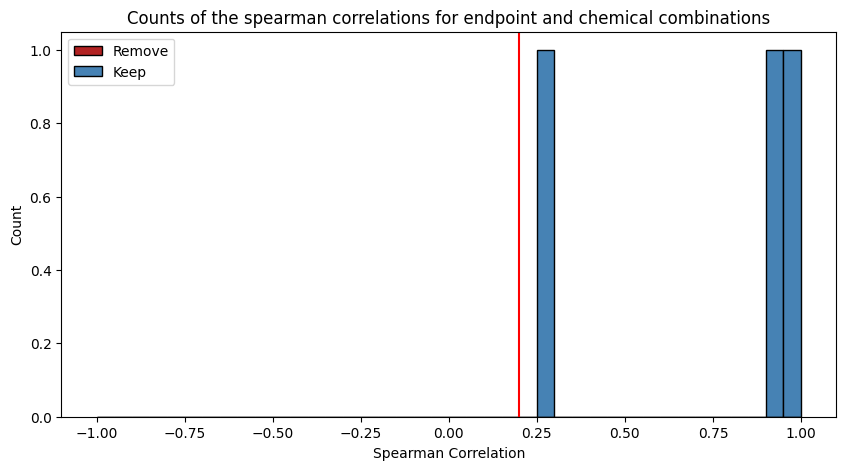

In [7]:
# View filter. There is no need to apply in this case. 
res_only.filter_correlation_score(score = 0.2, diagnostic_plot = True, apply = False)
res_only.filter_correlation_score_plot

## Module 4: Fit Models

All 7 EPA recommended models, including one additional model (Quantal Linear) are fit to the curve. The best fit is then selected in this order:

1. If the goodness-of-fit (GOF) is over the threshold (default of 0.1)

2. The lowest Akaike Information Criterion (AIC) within 2

3. If necessary, the lowest BMDL value 

The 7 recommended models are: Logistic, Log-Logistic, Probit, Log-Probit, Weibull, Gamma, and Multistage 2

In [8]:
# Set the model fits to the recommended GOF and AIC thresholds. Any models within the AIC threshold (within 2 of the lowest score, by default), are then decided by the model_selection method. 
# Currently, only "lowest BMDL" is supported. 
res_only.fit_models(gof_threshold = 0.1, aic_threshold = 2, model_selection = "lowest BMDL")

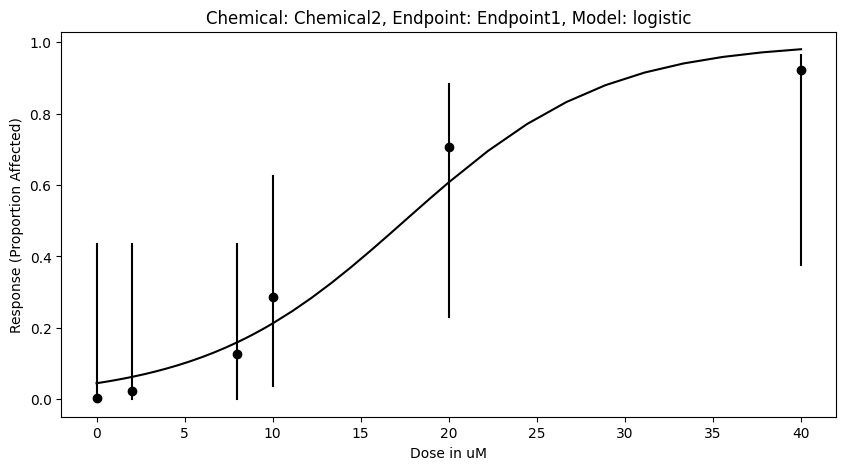

In [9]:
res_only.response_curve("Chemical2", "Endpoint1", "logistic")
res_only._Chemical2_Endpoint1_logistic_curve_plot

## Module 5: Output Modules

In [10]:
res_only.output_benchmark_dose()
res_only.output_res_benchmark_dose

,Chemical_ID,End_Point,Model,BMD10,BMDL,BMD50,AUC,Min_Dose,Max_Dose,AUC_Norm,DataQC_Flag,BMD_Analysis_Flag,BMD10_Flag,BMD50_Flag,bmdrc.Endpoint.ID
0,Chemical2,Endpoint2,Quantal Linear,20.332844,3.207443,133.765988,3.680000,0.0,40.0,0.092000,2,1,1,0,Chemical2 Endpoint2
0,Chemical3,Endpoint2,NaN,NaN,NaN,NaN,0.050000,0.0,1.0,0.050000,1,0,0,0,Chemical3 Endpoint2
0,Chemical2,Endpoint1,NaN,NaN,NaN,NaN,24.650000,0.0,40.0,0.616250,0,0,0,0,Chemical2 Endpoint1
1,DTXSID7020182,202992,NaN,NaN,NaN,NaN,32.747014,0.0,90.0,0.363856,0,0,0,0,DTXSID7020182 202992


In [11]:
res_only.output_dose_table()
res_only.output_res_dose_table

,Chemical_ID,End_Point,Dose,bmdrc.Endpoint.ID,num.affected,num.nonna,CI_Lo,CI_Hi
0,Chemical2,Endpoint1,0.000,Chemical2 Endpoint1,0.0200,5,0.000000,0.434482
1,Chemical2,Endpoint1,2.000,Chemical2 Endpoint1,0.1200,5,0.000000,0.434482
2,Chemical2,Endpoint1,8.000,Chemical2 Endpoint1,0.6300,5,0.000000,0.434482
3,Chemical2,Endpoint1,10.000,Chemical2 Endpoint1,1.4300,5,0.036224,0.624465
4,Chemical2,Endpoint1,20.000,Chemical2 Endpoint1,3.5300,5,0.230724,0.882379
5,Chemical2,Endpoint1,40.000,Chemical2 Endpoint1,4.6100,5,0.375535,0.963776
6,Chemical2,Endpoint2,0.000,Chemical2 Endpoint2,0.0000,1,0.000000,0.793451
7,Chemical2,Endpoint2,2.000,Chemical2 Endpoint2,0.0000,1,0.000000,0.793451
8,Chemical2,Endpoint2,8.000,Chemical2 Endpoint2,0.0800,1,0.000000,0.793451
9,Chemical2,Endpoint2,10.000,Chemical2 Endpoint2,0.0600,1,0.000000,0.793451


In [12]:
res_only.output_fits_table()
res_only.output_res_fits_table

,Chemical_ID,End_Point,X_vals,Y_vals,bmdrc.Endpoint.ID
0,DTXSID7020182,202992,NaN,NaN,DTXSID7020182 202992
0,Chemical2,Endpoint1,NaN,NaN,Chemical2 Endpoint1
0,Chemical2,Endpoint2,0.0000,0.000010,Chemical2 Endpoint2
1,Chemical2,Endpoint2,0.2222,0.001161,Chemical2 Endpoint2
2,Chemical2,Endpoint2,0.4444,0.002310,Chemical2 Endpoint2
3,Chemical2,Endpoint2,0.6667,0.003459,Chemical2 Endpoint2
4,Chemical2,Endpoint2,0.8889,0.004605,Chemical2 Endpoint2
5,Chemical2,Endpoint2,1.1111,0.005751,Chemical2 Endpoint2
6,Chemical2,Endpoint2,1.3333,0.006895,Chemical2 Endpoint2
7,Chemical2,Endpoint2,1.5556,0.008038,Chemical2 Endpoint2
